# Датасет adult (эталонный)

In [1]:
import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score

from auxiliary import *

imagespath = 'C:/Users/Acer/PycharmProjects/BAMTclone/BAMT/experiments2/images'

- age: the age of an individual
- workclass: a general term to represent the employment status of an individual
- education_num: the highest level of education achieved in numerical form.
- capital_gain: capital gains for an individual
- capital_loss: capital loss for an individual
- hours_per_week: the hours an individual has reported to work per week
- wage: whether or not an individual makes more than $50,000 annually ( <=50k, >50k)


- Уровни признаков после разбиения выносятся в отдельные столбцы в результате one-hot encoding и номер в конце имени признака обозначает уровень этого признака: 0 --- наименьшие значения, 2 --- наибольшие
- Ручное разбиение не рассматривалось, рассмотрены лишь разбиения признаков по уровням по квантилям и равномерное разбиение. У обоих подходов есть свои проблемы: по квантилям можно получить либо меньше уровней разбиения (в том числе и лишь один уровень, так как квантили могут совпасть), а равномерное разбиение может приводить к тому, что данному уровню признака может отвечать малый объём выборки в сравнении с остальными уровнями
- Также рассматривалась зависимость от выбора скора, по которому строится БС. mutual info даёт более простую сеть, чем BIC в рамках подхода с использованием one-hot encoding уровней признаков
- Поскольку нам неинтересно взаимодействие различных уровней одного и того же признака, нужно исключать соответствующие дуги в БС из white-list

In [2]:
data = pd.read_csv("adult.data", sep=',', names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage'])
data.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [3]:
data['wage'] = data['wage'].astype('string')
data['nwage'] = 0
data.loc[data[data['wage'].apply(lambda x: '>' in x)].index, 'nwage'] = 1

In [4]:
((data['capital_loss']>0)&(data['capital_gain']>0)).sum()

0

## Разбиение признаков по квантилям

In [5]:
cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'nwage']

In [6]:
np.random.seed(SEED)
random.seed(SEED)

qresult = construct_by_quantiles(data[cols], ['nwage'])
bn = qresult['bn']

c=bn.plot2(imagespath , "bn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


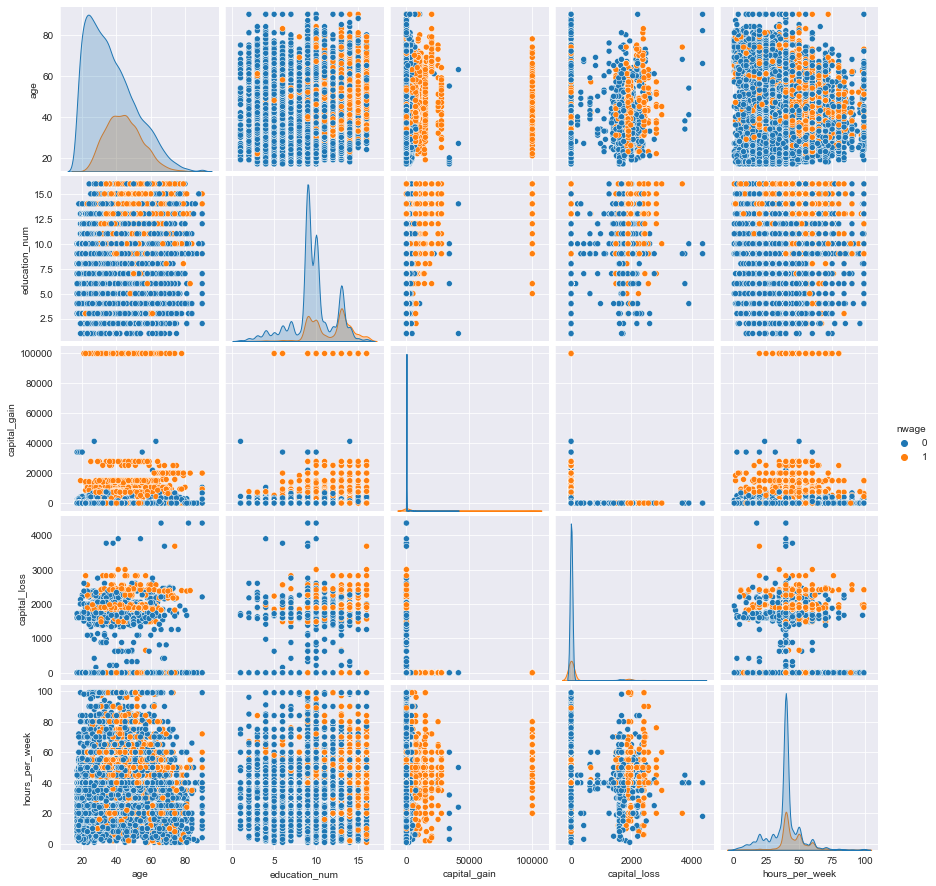

In [7]:
import seaborn as sns
sns.pairplot(data[cols], hue='nwage')

![](images/bn12.png)

In [16]:
c=bn.plot_for_specific_nodes(['nwage0', 'nwage1'], imagespath , "subbn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Равномерное разбиение признаков

In [8]:
np.random.seed(SEED)
random.seed(SEED)

uresult = construct_by_uniform(data[cols], ['nwage'])
ubn = uresult['bn']

c=ubn.plot2(imagespath , "ubn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/ubn12.png)

In [17]:
c=ubn.plot_for_specific_nodes(['nwage0', 'nwage1'], imagespath , "sububn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## KMeansDiscretizer с тремя bin'ами

In [9]:
np.random.seed(SEED)
random.seed(SEED)

kresult = construct_by_kmeans(data[cols], ['nwage'])
kbn = kresult['bn']

c=kbn.plot2(imagespath , "kbn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [10]:
kencoder, data_kdiscretized_enc = kresult['encoder'], kresult['disc_data']

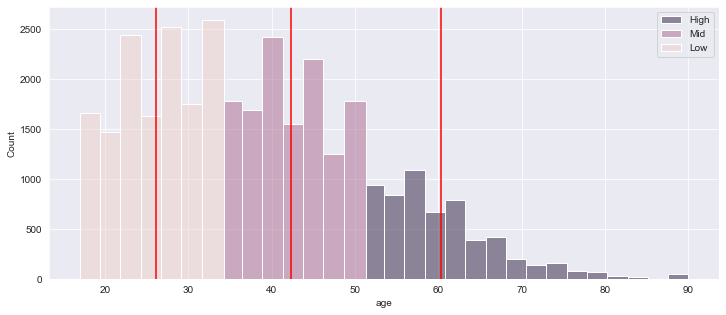

In [11]:
print_histogram('age', data, data_kdiscretized_enc, kencoder)

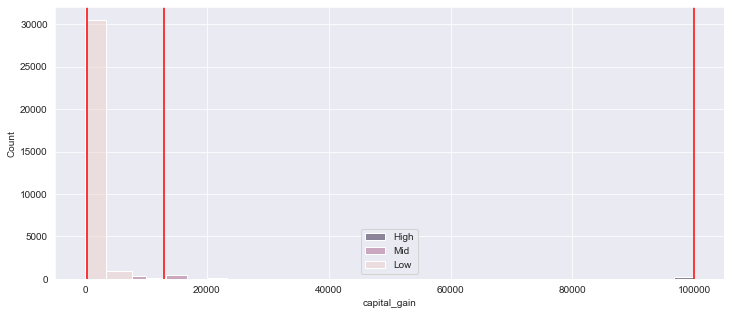

In [12]:
print_histogram('capital_gain', data, data_kdiscretized_enc, kencoder)

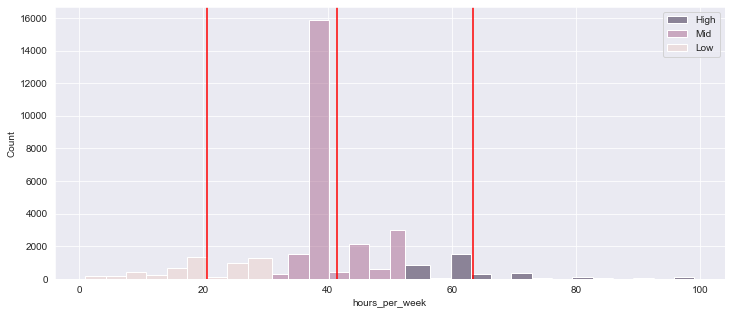

In [13]:
print_histogram('hours_per_week', data, data_kdiscretized_enc, kencoder)

![](images/kbn12.png)

In [18]:
c=kbn.plot_for_specific_nodes(['nwage0', 'nwage1'], imagespath , "subkbn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [14]:
all_edges = list(set(["-".join(e) for e in bn.edges + ubn.edges + kbn.edges])) #white list for the next bn

In [15]:
tradeoffbn = Nets.DiscreteBN()
nodes = list(dict.fromkeys(sum([x.split("-") for x in all_edges], start=[])))
tradeoffbn.add_nodes(dict(types={cat: 'disc' for _, cat in enumerate(nodes)}))

params = {'white_list': [(x[0], x[1]) for x in [y.split("-") for y in all_edges]]}

tradeoffbn.add_edges(data_kdiscretized_enc.astype("int32"), scoring_function=("K2",K2Score), params=params)

c=tradeoffbn.plot2(imagespath, "tbn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

  0%|          | 0/1000000 [00:00<?, ?it/s]

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [19]:
c=tradeoffbn.plot_for_specific_nodes(['nwage0', 'nwage1'], imagespath , "subtbn12.html", custom_mapper={'nwage': {0: '<50K', 1: '>=50K'}})

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
